In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.enable_eager_execution()

In [4]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

In [5]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# 1. Make Data X_train, y_train, X_test, y_test

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [7]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_211018_includeDigest.csv')
df_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_211018_includeDigest.csv')

inp = open(file_path+'detect_peptide_train_noptm_largedata.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y_noptm_largedata.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_noptm_largedata.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y_noptm_largedata.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

# 2. train

# 2-2. Github code

In [8]:
args = file_path + 'detect_peptide_train_noptm_largedata.txt'
print('Loading input peptides')
X_train81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y_noptm_largedata.txt')
y_train81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm_largedata.txt'
print('Loading input peptides')
X_test81, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y_noptm_largedata.txt')
y_test81 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train81, X_val81, y_train81, y_val81 = train_test_split(X_train81, y_train81, test_size=0.2)
print(X_train81.shape, X_val81.shape, X_test81.shape, y_train81.shape, y_val81.shape, y_test81.shape)


print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')
print(model_2_1D.summary())

Loading input peptides
Succesfully loaded 641892 peptides and skipped 0
Loading input peptides
Succesfully loaded 129204 peptides and skipped 0
(513513, 81) (128379, 81) (129204, 81) (513513,) (128379,) (129204,)
Loading model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 128)           19328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 64)            16448     
____________________________________________________________

In [9]:
for i in range(len(model_2_1D.weights)):
    print(i, model_2_1D.weights[i].name, model_2_1D.weights[i].shape)

0 embedding_1/embeddings:0 (23, 50)
1 conv1d_1/kernel:0 (3, 50, 128)
2 conv1d_1/bias:0 (128,)
3 conv1d_2/kernel:0 (2, 128, 64)
4 conv1d_2/bias:0 (64,)
5 dense_2/kernel:0 (64, 64)
6 dense_2/bias:0 (64,)
7 dense_3/kernel:0 (64, 1)
8 dense_3/bias:0 (1,)


In [10]:
print(model_2_1D.get_layer(index=0).get_weights()[0].shape,
      model_2_1D.get_layer(index=1).get_weights(),
      model_2_1D.get_layer(index=2).get_weights()[0].shape,
      model_2_1D.get_layer(index=2).get_weights()[1].shape,
      model_2_1D.get_layer(index=3).get_weights()[0].shape,
      model_2_1D.get_layer(index=3).get_weights()[1].shape,
      model_2_1D.get_layer(index=4).get_weights(),
      model_2_1D.get_layer(index=5).get_weights()[0].shape,
      model_2_1D.get_layer(index=5).get_weights()[1].shape,
      model_2_1D.get_layer(index=6).get_weights(),
      model_2_1D.get_layer(index=7).get_weights(),
      model_2_1D.get_layer(index=8).get_weights()[0].shape,
      model_2_1D.get_layer(index=8).get_weights()[1].shape,
      model_2_1D.get_layer(index=9).get_weights())

(23, 50) [] (3, 50, 128) (128,) (2, 128, 64) (64,) [] (64, 64) (64,) [] [] (64, 1) (1,) []


In [11]:
model_2_1D.get_layer(index=0).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(23,50)).numpy()])
model_2_1D.get_layer(index=2).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(3,50,128)).numpy(),
     np.zeros(128,)])
model_2_1D.get_layer(index=3).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(2,128,64)).numpy(),
    np.zeros(64,)])
model_2_1D.get_layer(index=5).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,64)).numpy(),
    np.zeros(64,)])
model_2_1D.get_layer(index=8).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,1)).numpy(),
    np.zeros(1,)])

Train on 337179 samples, validate on 84295 samples
Epoch 1/200
337179/337179 [==============================] - 73s 215us/sample - loss: 0.4006 - acc: 0.8118 - binary_crossentropy: 0.4006 - val_loss: 0.3740 - val_acc: 0.8285 - val_binary_crossentropy: 0.3740
Epoch 2/200
337179/337179 [==============================] - 70s 208us/sample - loss: 0.3636 - acc: 0.8349 - binary_crossentropy: 0.3636 - val_loss: 0.3612 - val_acc: 0.8349 - val_binary_crossentropy: 0.3612
Epoch 3/200
337179/337179 [==============================] - 70s 209us/sample - loss: 0.3532 - acc: 0.8404 - binary_crossentropy: 0.3532 - val_loss: 0.3483 - val_acc: 0.8443 - val_binary_crossentropy: 0.3483
Epoch 4/200
337179/337179 [==============================] - 70s 209us/sample - loss: 0.3479 - acc: 0.8435 - binary_crossentropy: 0.3479 - val_loss: 0.3404 - val_acc: 0.8468 - val_binary_crossentropy: 0.3404
Epoch 5/200
337179/337179 [==============================] - 70s 209us/sample - loss: 0.3445 - acc: 0.8457 - binary_c

Epoch 40/200
337179/337179 [==============================] - 37s 111us/sample - loss: 0.3132 - acc: 0.8622 - binary_crossentropy: 0.3132 - val_loss: 0.3322 - val_acc: 0.8522 - val_binary_crossentropy: 0.3322
Epoch 41/200
337179/337179 [==============================] - 37s 111us/sample - loss: 0.3123 - acc: 0.8634 - binary_crossentropy: 0.3123 - val_loss: 0.3493 - val_acc: 0.8470 - val_binary_crossentropy: 0.3493
Epoch 42/200
337179/337179 [==============================] - 37s 111us/sample - loss: 0.3123 - acc: 0.8629 - binary_crossentropy: 0.3123 - val_loss: 0.3364 - val_acc: 0.8529 - val_binary_crossentropy: 0.3364
Epoch 43/200
337179/337179 [==============================] - 38s 111us/sample - loss: 0.3127 - acc: 0.8628 - binary_crossentropy: 0.3127 - val_loss: 0.3310 - val_acc: 0.8541 - val_binary_crossentropy: 0.3310
Epoch 44/200
337179/337179 [==============================] - 37s 111us/sample - loss: 0.3121 - acc: 0.8631 - binary_crossentropy: 0.3121 - val_loss: 0.3324 - val_a

337179/337179 [==============================] - 38s 111us/sample - loss: 0.2991 - acc: 0.8689 - binary_crossentropy: 0.2991 - val_loss: 0.3356 - val_acc: 0.8520 - val_binary_crossentropy: 0.3356
Epoch 119/200
337179/337179 [==============================] - 38s 111us/sample - loss: 0.2990 - acc: 0.8692 - binary_crossentropy: 0.2990 - val_loss: 0.3394 - val_acc: 0.8522 - val_binary_crossentropy: 0.3394
Epoch 120/200
337179/337179 [==============================] - 38s 112us/sample - loss: 0.2990 - acc: 0.8694 - binary_crossentropy: 0.2990 - val_loss: 0.3357 - val_acc: 0.8529 - val_binary_crossentropy: 0.3357
Epoch 121/200
337179/337179 [==============================] - 38s 112us/sample - loss: 0.2989 - acc: 0.8700 - binary_crossentropy: 0.2989 - val_loss: 0.3375 - val_acc: 0.8515 - val_binary_crossentropy: 0.3375
Epoch 122/200
337179/337179 [==============================] - 38s 112us/sample - loss: 0.2988 - acc: 0.8700 - binary_crossentropy: 0.2988 - val_loss: 0.3346 - val_acc: 0.853

Epoch 157/200
337179/337179 [==============================] - 105s 313us/sample - loss: 0.2965 - acc: 0.8703 - binary_crossentropy: 0.2965 - val_loss: 0.3362 - val_acc: 0.8521 - val_binary_crossentropy: 0.3362
Epoch 158/200
337179/337179 [==============================] - 106s 313us/sample - loss: 0.2963 - acc: 0.8707 - binary_crossentropy: 0.2963 - val_loss: 0.3473 - val_acc: 0.8490 - val_binary_crossentropy: 0.3473
Epoch 159/200
337179/337179 [==============================] - 104s 310us/sample - loss: 0.2959 - acc: 0.8711 - binary_crossentropy: 0.2959 - val_loss: 0.3445 - val_acc: 0.8519 - val_binary_crossentropy: 0.3445
Epoch 160/200
337179/337179 [==============================] - 105s 311us/sample - loss: 0.2954 - acc: 0.8717 - binary_crossentropy: 0.2954 - val_loss: 0.3389 - val_acc: 0.8528 - val_binary_crossentropy: 0.3389
Epoch 161/200
337179/337179 [==============================] - 106s 314us/sample - loss: 0.2963 - acc: 0.8705 - binary_crossentropy: 0.2963 - val_loss: 0.34

Epoch 196/200
337179/337179 [==============================] - 70s 207us/sample - loss: 0.2944 - acc: 0.8714 - binary_crossentropy: 0.2944 - val_loss: 0.3512 - val_acc: 0.8461 - val_binary_crossentropy: 0.3512
Epoch 197/200
337179/337179 [==============================] - 69s 205us/sample - loss: 0.2941 - acc: 0.8717 - binary_crossentropy: 0.2941 - val_loss: 0.3523 - val_acc: 0.8472 - val_binary_crossentropy: 0.3523
Epoch 198/200
337179/337179 [==============================] - 69s 205us/sample - loss: 0.2938 - acc: 0.8719 - binary_crossentropy: 0.2938 - val_loss: 0.3529 - val_acc: 0.8482 - val_binary_crossentropy: 0.3529
Epoch 199/200
337179/337179 [==============================] - 69s 204us/sample - loss: 0.2943 - acc: 0.8714 - binary_crossentropy: 0.2943 - val_loss: 0.3511 - val_acc: 0.8463 - val_binary_crossentropy: 0.3511
Epoch 200/200
337179/337179 [==============================] - 69s 204us/sample - loss: 0.2941 - acc: 0.8719 - binary_crossentropy: 0.2941 - val_loss: 0.3463 - 

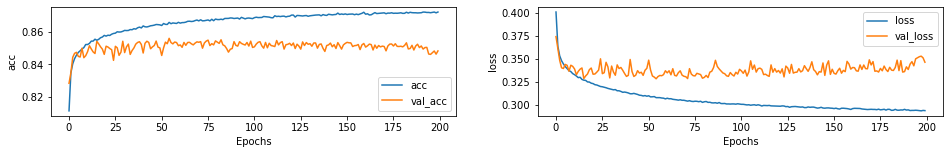

In [12]:
history_github = model_2_1D.fit(X_train81, y_train81, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val81, y_val81))

plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history_github, 'acc')
plt.subplot(1,2,2)
plot_graphs(history_github, 'loss')

# 3. test

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

129204/129204 [==============================] - 15s 119us/sample - loss: 2.6286 - acc: 0.2399 - binary_crossentropy: 2.6286
Test Accuracy: [2.628602079428267, 0.23992291, 2.6286042]
              precision    recall  f1-score   support

           0       0.22      0.20      0.21     64602
           1       0.26      0.28      0.27     64602

    accuracy                           0.24    129204
   macro avg       0.24      0.24      0.24    129204
weighted avg       0.24      0.24      0.24    129204

rf auc : 0.16910318525062987


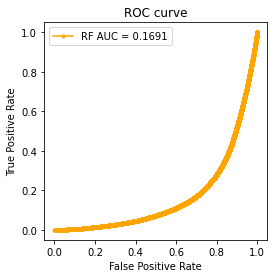

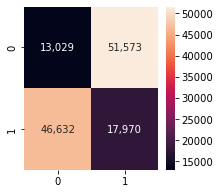

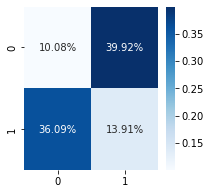

In [10]:
test_acc = model_2_1D.evaluate(X_test81, y_test81)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test81)]
print(classification_report(y_test81, y_pred))
# AUC
probs = model_2_1D.predict(X_test81)
rf_auc = roc_auc_score(y_test81, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test81, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test81, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [42]:
model_2_1D.get_layer(index=0).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(23,50)).numpy()])
model_2_1D.get_layer(index=1).set_weights([])
model_2_1D.get_layer(index=2).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(3,50,128)).numpy(),
     np.zeros(128,)])
model_2_1D.get_layer(index=3).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(2,128,64)).numpy(),
    np.zeros(64,)])
model_2_1D.get_layer(index=4).set_weights([])
model_2_1D.get_layer(index=5).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,64)).numpy(),
    np.zeros(64,)])
model_2_1D.get_layer(index=6).set_weights([])
model_2_1D.get_layer(index=7).set_weights([])
model_2_1D.get_layer(index=8).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,1)).numpy(),
    np.zeros(1,)])
model_2_1D.get_layer(index=9).set_weights([])

129204/129204 [==============================] - 15s 115us/sample - loss: 0.6994 - acc: 0.5000 - binary_crossentropy: 0.6994
Test Accuracy: [0.6994260144393875, 0.5, 0.6994263]


/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bis/miniconda3/envs/TF1.14/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     64602
           1       0.50      1.00      0.67     64602

    accuracy                           0.50    129204
   macro avg       0.25      0.50      0.33    129204
weighted avg       0.25      0.50      0.33    129204

rf auc : 0.5097515657574601


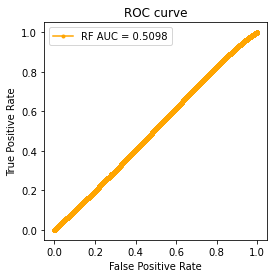

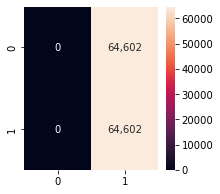

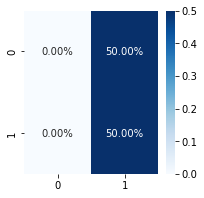

In [43]:
test_acc = model_2_1D.evaluate(X_test81, y_test81)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test81)]
print(classification_report(y_test81, y_pred))
# AUC
probs = model_2_1D.predict(X_test81)
rf_auc = roc_auc_score(y_test81, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test81, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test81, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# DeepMSpeptide의 파라메터 초기화가필요하다.